# Link to the lab

https://tinyurl.com/inlplab5

# Setup

We'll use fasttext wiki embeddings in our embedding layer

In [4]:
!pip install fasttext
!pip install datasets
!pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.1.2-cp310-cp310-macosx_10_9_x86_64.whl (8.7 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import io
from math import log
from numpy import array
from numpy import argmax
import torch
import random
from math import log
from numpy import array
from numpy import argmax
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import heapq

In [6]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

# Sequence Classification - recap



Sequence classification is the task of 
- predicting a class (e.g., POS tag) for each separate token in a textual input
- label tokens as beginning (B), inside (I), or outside (O) 
- predicting which tokens from the input belong to a span, e.g.:
  - which tokens from a document answer a given question (extractive QA)
![](https://rajpurkar.github.io/mlx/qa-and-squad/example-squad.png)
  - which tokens in a news article contain propagandistic techniques
![](https://d3i71xaburhd42.cloudfront.net/237a2b25e1ced676b0ebe8ccaa0cd4b7c5adac6b/5-Figure2-1.png)
  - the spans can be of different types, e.g. type of a Named Entity (NE) -- Person, Location, Organisation
  - ([More datasets for structured prediction](https://huggingface.co/datasets?languages=languages:en&task_categories=task_categories:structure-prediction&sort=downloads))

## Named entity recognition



- identify the **entities** that appear in a document and their types
- e.g., extract from the following sentence all names of the people, locations, and organizations:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
 <tr>
    <th class="tg-0pky">Sundar</th>
    <th class="tg-0pky">Pichai</th>
    <th class="tg-0pky">is</th>
    <th class="tg-0pky">the</th>
    <th class="tg-0pky">CEO</th>
    <th class="tg-0pky">of</th>
    <th class="tg-0pky">Alphabet</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">located</th>
    <th class="tg-0pky">in</th>
    <th class="tg-0pky">Mountain</th>
    <th class="tg-0pky">View</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">CA</th>
  </tr>
  <tr>
    <td class="tg-0pky">PER</td>
    <td class="tg-0pky">PER</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">ORG</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
  </tr>
</tbody>
</table>

- we have labelled all of the tokens associate with their classes as the given type (PER: Person, ORG: Organization, LOC: Location, O: Outside). **Question: What are some issues that could arise as a result of this tagging?

In practice, we will also want to denote which tokens are the beginning of an entity, and which tokens are inside the full entity span, giving the following tagging:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
 <tr>
    <th class="tg-0pky">Sundar</th>
    <th class="tg-0pky">Pichai</th>
    <th class="tg-0pky">is</th>
    <th class="tg-0pky">the</th>
    <th class="tg-0pky">CEO</th>
    <th class="tg-0pky">of</th>
    <th class="tg-0pky">Alphabet</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">located</th>
    <th class="tg-0pky">in</th>
    <th class="tg-0pky">Mountain</th>
    <th class="tg-0pky">View</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">CA</th>
  </tr>
  <tr>
    <td class="tg-0pky">B-PER</td>
    <td class="tg-0pky">I-PER</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">B-ORG</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">B-LOC</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
  </tr>
</tbody>
</table>

**Question: What are some other tagging schemes that you think could be good?**

Modeling the dependencies between the predictions can be useful: for example knowing that the previous tag was `B-PER` influences whether or not the current tag will be `I-PER` or `O` or `I-LOC`.

## Download and prepare the data

We'll use a small set of Wikipedia data labelled with people, locations, organizations, and "miscellaneous" entities.

In [7]:
datasets = load_dataset("conll2003")
datasets

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /Users/knf792/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [8]:
print(datasets['train'])
print(datasets['train'][0])
print(datasets["train"].features[f"ner_tags"])
print(datasets["train"].features[f"ner_tags"].feature.names)

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


We'll create the word embedding space:
- with FastText pretrained embeddings
- using all of the *vocabulary from the train and dev splits*, plus the most frequent tokens from the trained word embeddings. This will reduce the embeddings size!

In [9]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2022-10-06 09:18:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650,22M  11,9MB/s    in 49s     

2022-10-06 09:19:30 (13,3 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [10]:
# Reduce down to our vocabulary and word embeddings
def load_vectors(fname, vocabulary):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    tag_names = datasets["train"].features[f"ner_tags"].feature.names
    final_vocab = tag_names + ['[PAD]', '[UNK]', '[BOS]', '[EOS]']
    final_vectors = [np.random.normal(size=(300,)) for _ in range(len(final_vocab))]
    for j,line in enumerate(fin):
        tokens = line.rstrip().split(' ')
        if tokens[0] in vocabulary or len(final_vocab) < 30000:
            final_vocab.append(tokens[0])
            final_vectors.append(np.array(list(map(float, tokens[1:]))))
    return final_vocab, np.vstack(final_vectors)

class FasttextTokenizer:
    def __init__(self, vocabulary):
        self.vocab = {}
        for j,l in enumerate(vocabulary):
            self.vocab[l.strip()] = j

    def encode(self, text):
        # Text is assumed to be tokenized
        return [self.vocab[t] if t in self.vocab else self.vocab['[UNK]'] for t in text]

In [11]:
vocabulary = (set([t for s in datasets['train'] for t in s['tokens']]) | set([t for s in datasets['validation'] for t in s['tokens']]))
vocabulary, pretrained_embeddings = load_vectors('wiki-news-300d-1M.vec', vocabulary)
print('size of vocabulary: ', len(vocabulary))
tokenizer = FasttextTokenizer(vocabulary)

size of vocabulary:  40630


The main difference in the dataset reading and collation functions is that we now return a sequence of labels instead of a single label as in text classification.

In [21]:
def collate_batch_bilstm(input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_ids = [tokenizer.encode(i['tokens']) for i in input_data]
    seq_lens = [len(i) for i in input_ids]
    labels = [i['ner_tags'] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [0] * (max_length - len(i))) for i in input_ids]
    labels = [(i + [0] * (max_length - len(i))) for i in labels] # 0 is the id of the O tag

    assert (all(len(i) == max_length for i in input_ids))
    assert (all(len(i) == max_length for i in labels))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

In [23]:
dev_dl = DataLoader(datasets['validation'], batch_size=1, shuffle=False, collate_fn=collate_batch_bilstm, num_workers=0)
next(iter(dev_dl))

(tensor([[36231,    48,    10, 33561, 30770,  8120, 31121, 21803,    10, 36750,
             15]]),
 tensor([11]),
 tensor([[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [14]:
print(datasets['validation'][0])
print(collate_batch_bilstm([datasets['validation'][0]]))

{'id': '0', 'tokens': ['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.'], 'pos_tags': [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7], 'chunk_tags': [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0], 'ner_tags': [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]}
(tensor([[36231,    48,    10, 33561, 30770,  8120, 31121, 21803,    10, 36750,
            15]]), tensor([11]), tensor([[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]]))


# Creating the model

## LSTM model for sequence classification

You'll notice that the BiLSTM model is mostly the same from the text classification and language modeling labs. 

In [16]:
# Define the model
class BiLSTM(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],  # input size
                lstm_dim,  # hidden size
                2,  # number of layers
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
        })
        self.n_classes = n_classes
        self.loss = nn.CrossEntropyLoss()
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, hidden_states = None, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN - https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        if hidden_states:
            lstm_out, hidden = self.model['bilstm'](lstm_in, hidden_states)
        else:
            lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out, lengths = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get logits (b x seq_len x n_classes)
        logits = self.model['ff'](lstm_out)
        outputs = (logits, lengths)
        if labels is not None:
            loss = self.loss(logits.reshape(-1, self.n_classes), labels.reshape(-1))
            outputs =  outputs + (loss,)

        return outputs

In [75]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler=None,
):
    """
    The main training loop which will optimize a given model on a given dataset
    :param model: The model being optimized
    :param train_dl: The training dataset
    :param valid_dl: A validation dataset
    :param optimizer: The optimizer used to update the model parameters
    :param n_epochs: Number of epochs to train for
    :param device: The device to train on
    :return: (model, losses) The best model and the losses per iteration
    """

  # Keep track of the loss and best accuracy
    losses = []
    learning_rates = []
    best_f1 = 0.0

    # Iterate through epochs
    for ep in range(n_epochs):

        loss_epoch = []

        #Iterate through each batch in the dataloader
        for batch in tqdm(train_dl):
            # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
            # things like dropout and layer normalization
            model.train()

            # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
            # keeps track of these dynamically in its computation graph so you need to explicitly
            # zero them out
            optimizer.zero_grad()

            # Place each tensor on the GPU
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]

            # Pass the inputs through the model, get the current loss and logits
            logits, lengths, loss = model(input_ids, seq_lens, labels=labels)
            losses.append(loss.item())
            loss_epoch.append(loss.item())

            # Calculate all of the gradients and weight updates for the model
            loss.backward()

            # Optional: clip gradients
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Finally, update the weights of the model
            optimizer.step()
            if scheduler != None:
                scheduler.step()
                learning_rates.append(scheduler.get_last_lr()[0])

        # Perform inline evaluation at the end of the epoch
        f1 = evaluate(model, valid_dl)
        print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

        # Keep track of the best model based on the accuracy
        if f1 > best_f1:
            torch.save(model.state_dict(), 'best_model')
            best_f1 = f1

    return losses, learning_rates

In [76]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
    # layer normalization and dropout
    model.eval()
    labels_all = []
    preds_all = []

    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]
            hidden_states = None

            logits, _, _ = model(input_ids, seq_lens, hidden_states=hidden_states, labels=labels)
            preds_all.extend(torch.argmax(logits, dim=-1).reshape(-1).detach().cpu().numpy())
            labels_all.extend(labels.reshape(-1).detach().cpu().numpy())

    P, R, F1, _ = precision_recall_fscore_support(labels_all, preds_all, average='macro')
    print(confusion_matrix(labels_all, preds_all))
    return F1

In [77]:
lstm_dim = 128
dropout_prob = 0.1
batch_size = 8
lr = 1e-2
n_epochs = 10
n_workers = 0  # set to a larger number if you run your code in colab

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# Create the model
model = BiLSTM(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(datasets["train"].features[f"ner_tags"].feature.names)
  ).to(device)

In [78]:
train_dl = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=n_workers)
valid_dl = DataLoader(datasets['validation'], batch_size=len(datasets['validation']), collate_fn=collate_batch_bilstm, num_workers=n_workers)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

# Train
losses, learning_rates = train(model, train_dl, valid_dl, optimizer, n_epochs, device, scheduler)
model.load_state_dict(torch.load('best_model'))

  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345419     47     10     49     52     14      2     41     13]
 [    23   1789      5      1      0     20      0      3      1]
 [    25     16   1260      0      4      0      0      1      1]
 [    37     82      0   1135     27     44      0     16      0]
 [    32      5     11      8    678      2     10      1      4]
 [    25     12      0     34      8   1741      3     14      0]
 [     6      0      0      0     37      2    211      0      1]
 [    65     17      0     34      3     22      1    775      5]
 [    47      1      5      0     51      1      5     16    220]]
Validation F1: 0.8935076155280685, train loss: 0.14170506390146825


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345436     62      2     45     22     11      2     33     34]
 [    31   1781      5      4      0     14      0      6      1]
 [    25     22   1249      2      1      0      2      1      5]
 [    23     56      1   1191     21     22      0     27      0]
 [    49      5     15      7    613     11     13      3     35]
 [    25     13      0     50      0   1727      1     21      0]
 [    11      0      3      1     12      7    211      1     11]
 [    43     17      0     35      1      6      0    813      7]
 [    27      2      5      0     16      2      0     18    276]]
Validation F1: 0.9018831260482847, train loss: 0.02657376601092108


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345456     29     14     48     20     20      0     37     23]
 [    27   1752     18     20      1     20      0      4      0]
 [    17      9   1273      1      0      0      1      1      5]
 [    38     23      1   1216     15     23      0     25      0]
 [    36      1     10      8    659      2     10      0     25]
 [    12      8      0     62      3   1727      4     20      1]
 [     8      0      0      1     23      3    214      2      6]
 [    41     12      0     47      3      8      0    793     18]
 [    27      1      6      1     19      2      0      7    283]]
Validation F1: 0.9104821085939905, train loss: 0.017478332217572713


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345508     31      3     37     10     10      1     23     24]
 [    23   1794      7      7      0      7      0      3      1]
 [    21     11   1272      0      0      0      0      1      2]
 [    50     50      0   1190     12     19      0     19      1]
 [    50      2     25     12    628      2     10      2     20]
 [    29     20      0     51      4   1695      1     35      2]
 [    11      0      6      0     14      3    212      1     10]
 [    75     12      0     28      1      6      0    795      5]
 [    32      1      5      0     12      2      2     15    277]]
Validation F1: 0.9107918478008801, train loss: 0.012492643622691443


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345519     20      2     40     25     10      0     21     10]
 [    29   1776      6     13      2     13      0      2      1]
 [    25     11   1268      0      1      0      0      1      1]
 [    37     19      1   1222     12     30      0     20      0]
 [    49      0      9     11    661      6      5      1      9]
 [    14      7      0     36      3   1761      1     14      1]
 [    11      0      0      0     19      2    221      0      4]
 [    62     10      0     33      3      8      0    801      5]
 [    30      1      5      3     24      2      1     12    268]]
Validation F1: 0.9245278623743088, train loss: 0.008772710909356139


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345475     33      2     25     41     20      1     36     14]
 [    25   1782      3      4      2     21      0      4      1]
 [    21     16   1260      1      3      0      2      2      2]
 [    40     38      0   1170     30     34      1     28      0]
 [    34      0     10      3    674      9      7      0     14]
 [    16      7      0     28      3   1757      3     21      2]
 [    10      0      3      0     14      3    225      0      2]
 [    62     13      0     26      3     14      0    792     12]
 [    30      1      6      2     16      1      5     20    265]]
Validation F1: 0.9140443357471715, train loss: 0.00545991696425629


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345466     14      2     56     29     14      2     40     24]
 [    25   1767      2     23      1     18      1      4      1]
 [    21     10   1261      1      6      0      4      1      3]
 [    29     21      0   1224     16     24      1     26      0]
 [    34      1      7      9    677      5      6      0     12]
 [     7      5      0     46      2   1758      2     16      1]
 [     9      0      0      0     13      3    227      0      5]
 [    47      8      0     39      3      8      0    811      6]
 [    28      2      5      2     19      2      3     11    274]]
Validation F1: 0.9206964790962123, train loss: 0.0035528619892963883


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345500     35      3     28     10     19      2     29     21]
 [    19   1794      2      7      1     14      0      4      1]
 [    22     12   1262      1      5      0      2      1      2]
 [    39     43      0   1201     10     28      1     18      1]
 [    44      1     12      7    650      6     12      1     18]
 [    10      7      0     41      2   1762      2     12      1]
 [     9      0      0      0      7      2    235      0      4]
 [    55     16      0     27      3     13      0    801      7]
 [    29      1      4      1      9      2      8     13    279]]
Validation F1: 0.9228745320291222, train loss: 0.0022250179169699172


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345500     28      2     41     23     10      2     23     18]
 [    21   1784      2     15      1     13      0      5      1]
 [    21     10   1262      2      6      0      1      1      4]
 [    28     36      1   1219     13     26      0     18      0]
 [    39      1     12      6    667      6      9      1     10]
 [     5      7      0     46      3   1761      2     13      0]
 [    11      0      0      0     10      2    232      0      2]
 [    53     11      0     31      3     10      0    808      6]
 [    30      0      4      1     21      1      3     14    272]]
Validation F1: 0.9249685641215538, train loss: 0.0012310007892623906


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345508     24      2     37     19     13      2     24     18]
 [    24   1780      2     14      1     15      0      5      1]
 [    20      9   1264      2      5      0      2      1      4]
 [    31     35      0   1220     12     26      1     16      0]
 [    41      0     12      8    665      7      7      1     10]
 [     7      4      0     43      3   1764      2     14      0]
 [    10      0      0      0     10      2    232      0      3]
 [    53     11      0     31      3     10      0    808      6]
 [    29      0      4      1     18      1      4     18    271]]
Validation F1: 0.925124536751276, train loss: 0.0008371544579220439


<All keys matched successfully>

# Learning rate schedules

Motivation: 
- speed up training
- to train a better model

With Pytorch:
- choose a learning rate schedulers form `torch.optim.lr_schedule`
- add a line in your training loop which calls the `step()` function of your scheduler
- this will automatically change your learning rate! 
- **Note**: be aware of when to call `step()`; some schedulers change the learning rate after every epoch, and some change after every training step (batch). The one we will use here changes the learning rate after every training step. We'll define the scheduler in the cell that calls the `train()` function. 

Set up hyperparameters and create the model. Note the high learning rate -- this is partially due to the learning rate scheduler we will use.

Above we have used the `CyclicLR` scheduler. The cyclic learning rate schedule in general looks like this:

![](https://ai-how.github.io/img/CLR.png) [Source](https://arxiv.org/pdf/1506.01186.pdf)

We are using it here to linearly decay the learning rate from a starting max learning rate (here 1e-2) down to 0 over the entire course of training (essentially one cycle that starts at the max and ends at 0). 

" Allowing the learning rate to rise and fall is beneficial overall
even though it might temporarily harm the network’s performance"

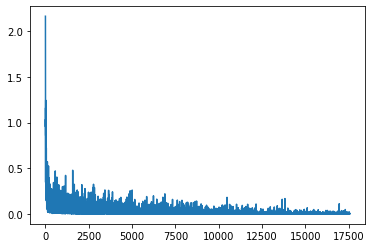

In [ ]:
plt.plot(losses)

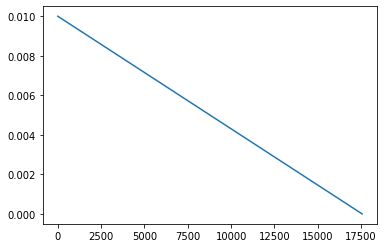

In [ ]:
plt.plot(learning_rates)

# Evaluate

In [29]:
test_dl = DataLoader(datasets['test'], batch_size=len(datasets['test']), collate_fn=collate_batch_bilstm, num_workers=n_workers)

evaluate(model, test_dl)

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[419531     57     20    157     74     86     12     76     47]
 [   113   1363     22     73      9     33      2      1      1]
 [    87      9   1042      2     13      1      2      0      0]
 [   116     27      2   1364     27     89      0     33      3]
 [    55      1      9     11    703      5     33      4     14]
 [    58     18      0     51      3   1502      4     31      1]
 [    27      0      6      0     14      7    202      0      1]
 [    71      9      1     37      6     16      0    557      5]
 [    32      0      3      1     14      3      8      6    149]]


0.8411122480145246

# Beam Search

![](https://miro.medium.com/max/700/1*tEjhWqUgjX37VnT7gJN-4g.png) [(source)](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)


In [79]:
# source https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences
 
# define a sequence of 10 words over a vocab of 5 words
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1]]
data = array(data)
# decode sequence
result = beam_search_decoder(data, 3)
# print result
for seq in result:
    print(seq)

[[4, 0, 4, 0, 4, 0, 4, 0, 4, 0], 6.931471805599453]
[[4, 0, 4, 0, 4, 0, 4, 0, 4, 1], 7.154615356913663]
[[4, 0, 4, 0, 4, 0, 4, 0, 3, 0], 7.154615356913663]


- **Question: Can you find what is the problem with the above?**


- In the above, when generating text, the probability distribution for the next step does not depend on the previous step's choice.
- Beam search is usually employed with encoder-decoder architectures:
![](https://miro.medium.com/max/700/1*GkG_5wg57IpkU8F84nJubQ.png)
- At each step, the decoder receives as input the prediction of the previous step and the hidden state of the previous step.
- During training : at each step provide either the prediction at the previous step with highest probability or the gold label for the next step (teacher forcing).
- During testing: build a beam of top-k generated sequences and re-run the decoder with each of them.

Resources:
- Implementing an encoder-decoder model [example 1](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), [example 2](https://bastings.github.io/annotated_encoder_decoder/)
- Implementing beam search [example](https://github.com/budzianowski/PyTorch-Beam-Search-Decoding/blob/master/decode_beam.py)


In [80]:
class EncoderRNN(nn.Module):
    """
    RNN Encoder model.
    """
    def __init__(self, 
            pretrained_embeddings: torch.tensor, 
            lstm_dim: int,
            dropout_prob: float = 0.1):
        """
        Initializer for EncoderRNN network
        :param pretrained_embeddings: A tensor containing the pretrained embeddings
        :param lstm_dim: The dimensionality of the LSTM network
        :param dropout_prob: Dropout probability
        """
        # First thing is to call the superclass initializer
        super(EncoderRNN, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, and an LSTM layer.
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'lstm': nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 2, batch_first=True, bidirectional=True),
        })
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :return: (lstm output state, lstm hidden state) 
        """
        embeds = self.model['embeddings'](inputs)
        lstm_in = nn.utils.rnn.pack_padded_sequence(
                    embeds,
                    input_lens.cpu(),
                    batch_first=True,
                    enforce_sorted=False
                )
        lstm_out, hidden_states = self.model['lstm'](lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        return lstm_out, hidden_states


class DecoderRNN(nn.Module):
    """
    RNN Decoder model.
    """
    def __init__(self, pretrained_embeddings: torch.tensor, 
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2):
        """
        Initializer for DecoderRNN network
        :param pretrained_embeddings: A tensor containing the pretrained embeddings
        :param lstm_dim: The dimensionality of the LSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: Number of prediction classes
        """
        # First thing is to call the superclass initializer
        super(DecoderRNN, self).__init__()
        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a LSTM layer, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'lstm': nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 2, bidirectional=True, batch_first=True),
            'nn': nn.Linear(lstm_dim*2, n_classes),
        })
        # Initialize the weights of the model
        self._init_weights()      

    def forward(self, inputs, hidden, input_lens):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param hidden: (b) The hidden state of the previous step
        :param input_lens: (b) The length of each input sequence
        :return: (output predictions, lstm hidden states) the hidden states will be used as input at the next step
        """
        embeds = self.model['embeddings'](inputs)

        lstm_in = nn.utils.rnn.pack_padded_sequence(
                    embeds,
                    input_lens.cpu(),
                    batch_first=True,
                    enforce_sorted=False
                )
        lstm_out, hidden_states = self.model['lstm'](lstm_in, hidden)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        output = self.model['nn'](lstm_out)
        return output, hidden_states

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters()) + list(self.model['nn'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

# Define the model
class Seq2Seq(nn.Module):
    """
    Basic Seq2Seq network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic Seq2Seq network
        :param pretrained_embeddings: A tensor containing the pretrained embeddings
        :param lstm_dim: The dimensionality of the LSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(Seq2Seq, self).__init__()

        # We'll define the network in a ModuleDict, which consists of an encoder and a decoder
        self.model = nn.ModuleDict({
            'encoder': EncoderRNN(pretrained_embeddings, lstm_dim, dropout_prob),
            'decoder': DecoderRNN(pretrained_embeddings, lstm_dim, dropout_prob, n_classes),
        })
        self.loss = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.5]+[1]*(len(datasets["train"].features[f"ner_tags"].feature.names)-1)).to(device))


    def forward(self, inputs, input_lens, labels=None):
        """
        Defines how tensors flow through the model. 
        For the Seq2Seq model this includes 1) encoding the whole input text, 
        and running *target_length* decoding steps to predict the tag of each token.

        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x embedding dim)
        encoder_output, encoder_hidden = self.model['encoder'](inputs, input_lens)
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([tokenizer.encode(['[BOS]'])]*inputs.shape[0], device=device)
        target_length = labels.size(1)

        loss = None
        for di in range(target_length):
            decoder_output, decoder_hidden = self.model['decoder'](
                decoder_input, decoder_hidden, torch.tensor([1]*inputs.shape[0]))

            if loss == None:   
                loss = self.loss(decoder_output.squeeze(1), labels[:, di])
            else:
                loss += self.loss(decoder_output.squeeze(1), labels[:, di])
            # Teacher forcing: Feed the target as the next input
            decoder_input = labels[:, di].unsqueeze(-1) 

        return loss / target_length

In [82]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
):
    """
    The main training loop which will optimize a given model on a given dataset
    :param model: The model being optimized
    :param train_dl: The training dataset
    :param valid_dl: A validation dataset
    :param optimizer: The optimizer used to update the model parameters
    :param n_epochs: Number of epochs to train for
    :param device: The device to train on
    :return: (model, losses) The best model and the losses per iteration
    """

    # Keep track of the loss and best accuracy
    losses = []
    best_f1 = 0.0

    # Iterate through epochs
    for ep in range(n_epochs):

        loss_epoch = []

        #Iterate through each batch in the dataloader
        for batch in tqdm(train_dl):
            # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
            # things like dropout and layer normalization
            model.train()

            # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
            # keeps track of these dynamically in its computation graph so you need to explicitly
            # zero them out
            optimizer.zero_grad()

            # Place each tensor on the GPU
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            labels = batch[2]
            input_lens = batch[1]

            # Pass the inputs through the model, get the current loss and logits
            loss = model(input_ids, labels=labels, input_lens=input_lens)
            losses.append(loss.item())
            loss_epoch.append(loss.item())

            # Calculate all of the gradients and weight updates for the model
            loss.backward()

            # Optional: clip gradients
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Finally, update the weights of the model
            optimizer.step()

        # Perform inline evaluation at the end of the epoch
        f1 = evaluate(model, valid_dl)
        print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

        # Keep track of the best model based on the accuracy
        if f1 > best_f1:
            torch.save(model.state_dict(), 'best_model')
            best_f1 = f1

    return losses

In [84]:
softmax = nn.Softmax(dim=-1)

def decode(model, inputs, input_lens, labels=None, beam_size=2):
    """
    Decoding/predicting the labels for an input text by running beam search.

    :param inputs: (b x sl) The IDs into the vocabulary of the input samples
    :param input_lens: (b) The length of each input sequence
    :param labels: (b) The label of each sample
    :param beam_size: the size of the beam 
    :return: predicted sequence of labels
    """

    assert inputs.shape[0] == 1
    # first, encode the input text
    encoder_output, encoder_hidden = model.model['encoder'](inputs, input_lens)
    decoder_hidden = encoder_hidden

    # the decoder starts generating after the Begining of Sentence (BOS) token
    decoder_input = torch.tensor([tokenizer.encode(['[BOS]',]),], device=device)
    target_length = labels.shape[1]
    
    # we will use heapq to keep top best sequences so far sorted in heap_queue 
    # these will be sorted by the first item in the tuple
    heap_queue = []
    heap_queue.append((torch.tensor(0), tokenizer.encode(['[BOS]']), decoder_input, decoder_hidden))

    # Beam Decoding
    for _ in range(target_length):
        # print("next len")
        new_items = []
        # for each item on the beam
        for j in range(len(heap_queue)): 
            # 1. remove from heap
            score, tokens, decoder_input, decoder_hidden = heapq.heappop(heap_queue)
            # 2. decode one more step
            decoder_output, decoder_hidden = model.model['decoder'](
                decoder_input, decoder_hidden, torch.tensor([1]))
            decoder_output = softmax(decoder_output)
            # 3. get top-k predictions
            best_idx = torch.argsort(decoder_output[0], descending=True)[0]
            # print(decoder_output)
            # print(best_idx)
            for i in range(beam_size):
                decoder_input = torch.tensor([[best_idx[i]]], device=device)
                
                new_items.append((score + decoder_output[0,0, best_idx[i]],
                                  tokens + [best_idx[i].item()], 
                                  decoder_input, 
                                  decoder_hidden))
        # add new sequences to the heap
        for item in new_items:
          # print(item)
            heapq.heappush(heap_queue, item)
        # remove sequences with lowest score (items are sorted in descending order)
        while len(heap_queue) > beam_size:
            heapq.heappop(heap_queue)
          
    final_sequence = heapq.nlargest(1, heap_queue)[0]
    assert labels.shape[1] == len(final_sequence[1][1:])
    return final_sequence

In [85]:
def evaluate(model: nn.Module, valid_dl: DataLoader, beam_size:int = 1):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
    # layer normalization and dropout
    model.eval()
    labels_all = []
    logits_all = []
    tags_all = []

    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            input_lens = batch[1]
            labels = batch[2]

            best_seq = decode(model, input_ids, input_lens, labels=labels, beam_size=beam_size)
            mask = (input_ids != 0)
            labels_all.extend([l for seq,samp in zip(list(labels.detach().cpu().numpy()), input_ids) for l,i in zip(seq,samp) if i != 0])
            tags_all += best_seq[1][1:]
            # print(best_seq[1][1:], labels)
    P, R, F1, _ = precision_recall_fscore_support(labels_all, tags_all, average='macro')
    print(confusion_matrix(labels_all, tags_all))
    return F1

In [88]:
lstm_dim = 300
dropout_prob = 0.1
batch_size = 64
lr = 1e-3
n_epochs = 20
n_workers = 0

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# Create the model
model = Seq2Seq(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(datasets["train"].features[f"ner_tags"].feature.names)
  ).to(device)

In [90]:
train_dl = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=n_workers)
valid_dl = DataLoader(datasets['validation'], batch_size=1, collate_fn=collate_batch_bilstm, num_workers=n_workers)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)
model.load_state_dict(torch.load('best_model'))

  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[40937   526   433   155   194   192    68    47   207]
 [  515  1052   218    15    13    14     3     2    10]
 [  379   146   758     3     9     3     3     1     5]
 [  467    49    19   686    66    32     5    10     7]
 [  285    12    25    65   323    10    13     5    13]
 [  627    35    10    91    23   951    46    35    19]
 [   92     4     5    12    26    22    79     1    16]
 [  535    16     8    24     9    34     6   246    44]
 [  154     5     5    22    24    18    12    14    92]]
Validation F1: 0.5148684803742811, train loss: 0.1254397713663903


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[40938   372   251   212   345   316    34   181   110]
 [  353  1221   148    35    26    28     2    20     9]
 [  329    94   822    14    28     5     0     3    12]
 [  275    39    10   820   114    43     2    32     6]
 [  190     2    17    58   435     8     7     6    28]
 [  404    21     3    66    24  1264    22    26     7]
 [   84     3     5     3    32    23    97     0    10]
 [  342    15     3    35    21    60     2   414    30]
 [  141     4     3     9    30    12    15    13   119]]
Validation F1: 0.5992961020420663, train loss: 0.08672628991983154


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41156   413   324   116   301   233    76    99    41]
 [  341  1254   170    13    19    29     4     7     5]
 [  279   119   866     2    16    12     5     3     5]
 [  249    59     8   851   109    38     5    18     4]
 [  137     9    24    30   511     6    13     5    16]
 [  345    27     9    59    25  1314    26    29     3]
 [   51     3     8     8    22    27   126     1    11]
 [  350    22     4    39    10    27     0   459    11]
 [  132     3     5    11    30     8    12    28   117]]
Validation F1: 0.6389387782477018, train loss: 0.06806593586436727


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[40798   449   320   148   528   183    57   120   156]
 [  225  1307   201    18    25    34     6     7    19]
 [  237    98   914     5    22    10     9     0    12]
 [  144    59    21   890   147    52     6    17     5]
 [   98     4    23    22   578     1     9     0    16]
 [  255    33     9    62    36  1372    25    21    24]
 [   36     1     5     4    38    14   139     2    18]
 [  266    33     8    66    27    30     1   450    41]
 [   83     5    10    10    68     1     6    12   151]]
Validation F1: 0.6429197452938862, train loss: 0.057959155670621175


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41519   298   217    66    69   183    18   135   254]
 [  255  1427   105     1     5    23     0     7    19]
 [  183   120   979     1     3     6     1     0    14]
 [  234    79     7   853    32    60     1    52    23]
 [  147     7    24    49   424    16    13     9    62]
 [  229    29    10    35     1  1476     7    33    17]
 [   41     1     6     1    18    24   153     0    13]
 [  265    15     1    16     2    17     1   568    37]
 [   76     5     8     9    13     8     5    32   190]]
Validation F1: 0.7031936004879823, train loss: 0.04639621409164234


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41100   261   184   172   518   160   125   102   137]
 [  181  1429   119    22    27    34     5     4    21]
 [  168    75   997     7    27    11     5     0    17]
 [   84    29    12   985   160    43     4    19     5]
 [   45     3    12     9   633     2    23     3    21]
 [  146    14     2    57    25  1539    30    14    10]
 [   19     0     3     2    27     8   192     0     6]
 [  159    22     2    54    28    35    11   574    37]
 [   52     2    10     7    48     2    14     9   202]]
Validation F1: 0.7135904551805614, train loss: 0.03937693921510469


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41380   226   245   125   370   126    34   118   135]
 [  188  1430   132    13    37    13     4     9    16]
 [  163    58  1035     1    34     2     2     0    12]
 [  103    60    10   978   129    28     3    22     8]
 [   45     4    31    24   621     2     9     2    13]
 [  162    29     5    94    23  1445    17    47    15]
 [   18     1    10     2    35    14   160     0    17]
 [  207    22     5    43    19    13     0   580    33]
 [   55     4    15     8    48     4     5    12   195]]
Validation F1: 0.7209686415011278, train loss: 0.03529796007258648


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41846   201   116   128   205   100    19    87    57]
 [  165  1507    98    21    16    22     0     6     7]
 [  154    66  1045     5    25     3     3     1     5]
 [   92    22    10  1051    95    48     1    21     1]
 [   72     3     3    21   619     3    17     3    10]
 [  139    12     1    75    11  1557    15    20     7]
 [   31     0     3     2    21    14   175     2     9]
 [  176    16     0    48    11    30     2   610    29]
 [   70     2     6     5    29     3     8    13   210]]
Validation F1: 0.7763060675321695, train loss: 0.030404941890050063


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41926   220   107    83   116   119     8   128    52]
 [  169  1527    93     7     4    26     1     9     6]
 [  201    69  1021     1     5     5     1     0     4]
 [   97    45     3   998    73    66     1    51     7]
 [   80     3    17    22   546     6    14     5    58]
 [  154    15     1    41     4  1566    11    39     6]
 [   34     0     4     0    14    14   174     2    15]
 [  156    15     0    30     3    24     1   673    20]
 [   77     1     7     5    18     3     5    22   208]]
Validation F1: 0.7765224797107156, train loss: 0.024601146790452978


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41690   257   165   140   109   143    55   114    86]
 [  152  1519   104    21     2    24     7     6     7]
 [  144    80  1061     3     4     4     7     0     4]
 [  104    34     9  1072    61    39     1    14     7]
 [   90     6    12    26   578     5    15     3    16]
 [  126    14     6    72     5  1560    19    21    14]
 [   21     0     3     1    22    11   186     0    13]
 [  152    19     3    51     9    27     1   635    25]
 [   67     1     8     4    32     3    14    16   201]]
Validation F1: 0.7671100558971141, train loss: 0.021562039246782662


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41929   121    84    86   314    85    32    76    32]
 [  149  1549    57    17    31    25     4     5     5]
 [  159    40  1061     6    34     1     4     0     2]
 [   66    25     4  1075    96    52     3    18     2]
 [   41     1     7    21   635     3    24     1    18]
 [   81    14     2    64    19  1622    16    17     2]
 [   20     1     4     3    37     8   180     0     4]
 [  132    16     2    47    18    22     1   665    19]
 [   62     3    10     2    23     3    16    12   215]]
Validation F1: 0.7923309583490342, train loss: 0.017838069995526562


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41880   187   148   114   141   112     9   102    66]
 [  175  1561    61    11     5    16     1     8     4]
 [  113    92  1079     4     6     4     4     0     5]
 [   91    31     5  1093    66    25     2    20     8]
 [   59     3     7    23   618     2    11     4    24]
 [  111    23     3    84     5  1562     8    30    11]
 [   15     0     5     5    32     9   180     1    10]
 [  131    17     2    47    11    16     2   672    24]
 [   51     1     9    10    25     1     3    17   229]]
Validation F1: 0.7990632659575675, train loss: 0.01514953335757706


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41927   225   153    97    89    94    21    88    65]
 [  157  1546    86    17     3    23     1     5     4]
 [  140    74  1072     7     6     4     0     1     3]
 [   86    43     4  1091    37    44     1    29     6]
 [   72     1     6    20   578     5    23     2    44]
 [  109    18     3    60     4  1606     7    25     5]
 [   18     0     3     4    21     7   192     1    11]
 [  146    17     2    39     3    18     1   676    20]
 [   52     2     4     7    19     2     4    26   230]]
Validation F1: 0.8022651715326824, train loss: 0.015754620486404747


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41978   195   158    90    87   129    13    67    42]
 [  149  1556    72    23     5    21     1    12     3]
 [  123    73  1088     4    12     0     2     1     4]
 [  107    30     5  1098    35    44     1    15     6]
 [   70     2     6    27   604     4    17     2    19]
 [  110    17     4    68     4  1599    11    18     6]
 [   22     0     1     1    22    14   185     1    11]
 [  157    24     3    46     5    23     3   643    18]
 [   58     2     8    12    27     6     9    23   201]]
Validation F1: 0.8001482986272885, train loss: 0.013831334230913357


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42161   163   113    72    47    80    12    71    40]
 [  164  1550    81     8     2    29     0     6     2]
 [  139    74  1078     2     4     3     4     0     3]
 [  103    29     1  1084    35    59     1    26     3]
 [   70     2     7    26   590     6    25     3    22]
 [  108    14     3    45     1  1636     9    20     1]
 [   23     0     2     2     9    15   197     1     8]
 [  162    15     0    27     2    21     1   682    12]
 [   56     2     8     3    13     3     7    22   232]]
Validation F1: 0.8245979034012647, train loss: 0.011220586808948692


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41968   188   124    98    86    96    27   106    66]
 [  167  1528    84    18     8    29     3     3     2]
 [  173    64  1048     0     4     3     8     5     2]
 [   81    34     6  1051    66    76     1    24     2]
 [   55     3    14    24   599     4    31     3    18]
 [   89     7     7    58     4  1632    11    26     3]
 [   18     1     2     2    19     6   199     1     9]
 [  139    10     2    32     5    16     3   698    17]
 [   59     1     5     3    17     2     8    20   231]]
Validation F1: 0.8035197642799284, train loss: 0.013202182106165724


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42038   168   125    68    86    94    43    84    53]
 [  163  1554    77    18     3    18     2     4     3]
 [  149    67  1082     1     2     3     1     0     2]
 [   84    39     8  1064    51    63     4    26     2]
 [   55     3     9    22   606     8    36     0    12]
 [   91    15     3    43     2  1643    19    18     3]
 [   11     0     6     0    16     9   209     0     6]
 [  140    20     0    30     4    13     1   693    21]
 [   49     4     8     4    25     2     5    12   237]]
Validation F1: 0.8160772657119046, train loss: 0.009503976078386503


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42097   164   114    80    66   105     6    91    36]
 [  148  1556    67    23     2    27     0    13     6]
 [  152    63  1063     1    10     8     1     0     9]
 [   87    28     4  1084    44    60     2    29     3]
 [   68     3     5    26   582     6    27     4    30]
 [   83    18     2    40     3  1657    10    23     1]
 [   21     0     2     0    15     6   204     0     9]
 [  132    16     0    24     2    22     3   709    14]
 [   61     0     5     4    11     2     8    13   242]]
Validation F1: 0.8246442255568004, train loss: 0.008092457134096714


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42137   129    89   100    91    70    12    73    58]
 [  139  1578    62    17     9    24     0    10     3]
 [  127    51  1103     5    12     4     0     1     4]
 [   78    26     3  1105    53    41     0    31     4]
 [   53     1     8    20   627     4    16     3    19]
 [   80    19     2    51     2  1653     9    17     4]
 [   18     0     2     0    23    11   195     0     8]
 [  120    15     0    33     6    13     0   711    24]
 [   50     2     8     6    21     3     5    17   234]]
Validation F1: 0.8295417224894234, train loss: 0.013141678918724541


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41750   220   126   184   113   160    28   100    78]
 [  156  1528    93    27    11    16     3     8     0]
 [  185    44  1052     2    15     4     2     1     2]
 [  113    31     3  1047    86    39     4    14     4]
 [   72     1     8    27   601     5    19     1    17]
 [  150    26     3    58     2  1567    16    13     2]
 [   23     0     9     1    20     7   196     0     1]
 [  129    16     0    42     8    25     2   670    30]
 [   52     2     8     4    28     4     6    13   229]]
Validation F1: 0.7906017625430706, train loss: 0.0177222935853272


<All keys matched successfully>

**Question: Do you have ideas how to improve the model?**
How about adding attention mechanism for the decoder to attend to the separate hidden states of the separate token steps in the encoder? (see the resources)


In [68]:
test_dl = DataLoader(datasets['test'], batch_size=1, collate_fn=collate_batch_bilstm, num_workers=n_workers)
evaluate(model, test_dl, beam_size=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/3453 [00:00<?, ?it/s]

[[37092   237   111   313   218    97    32   133    90]
 [  188  1254    51    73    19    20     0     9     3]
 [  177    55   868     3    38     4     4     3     4]
 [  133    58     4  1264    77    69     2    53     1]
 [   93     4    12    33   639     7    30     2    15]
 [  140    42     5   107    24  1304    11    32     3]
 [   26     0    10     4    33     9   165     1     9]
 [   94    23     6    57    10    16     1   479    16]
 [   45     3     8     1    23     1     2    11   122]]


0.727843916681434

In [69]:
evaluate(model, test_dl, beam_size=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/3453 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[37128   232   121   311   209    93    32   128    69]
 [  185  1270    49    68    14    18     0    10     3]
 [  163    60   887     4    32     2     1     3     4]
 [  135    64     5  1275    66    70     2    43     1]
 [   86     6    15    30   645     8    30     2    13]
 [  126    41     7   105    26  1314    16    31     2]
 [   28     0    10     4    36     7   167     0     5]
 [   92    26     6    61    10    16     2   476    13]
 [   48     2     8     1    22     1     2    12   120]]


0.7355817928230471

# Transformers for sequence classification

- have to adjust the vocabulary where a word is split into multiple word piesces
- [Tutorial on NER](https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb)
- Some generative transformers now perform the same as token classification transformers [e.g. T5 can extract the span of a tweet that contains a sentiment](https://github.com/enzoampil/t5-intro/blob/master/t5_qa_training_pytorch_span_extraction.ipynb)